In [2]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_validate
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from fancyimpute import KNN

import plotly.offline as py
from plotly.offline import download_plotlyjs, init_notebook_mode
import plotly.graph_objs as go

init_notebook_mode(connected=True)

train_path = "res/amazonReviews.800.train.csv"
test_path = "res/amazonReviews.700.test.csv"
result_folder = "results/"

test_set_ratio = 0.1 

In [3]:
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)
df_train.head(10)

,ID,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V9992,V9993,V9994,V9995,V9996,V9997,V9998,V9999,V10000,Class
0,545,5,4,3,2,2,3,1,1,2,...,0,0,0,0,0,0,0,1,0,Engineer
1,800,14,3,2,5,1,1,1,5,0,...,0,0,1,0,0,0,1,1,0,Kolln
2,1390,14,7,4,4,3,3,4,5,2,...,0,0,0,0,0,0,1,0,0,Vernon
3,1161,23,10,7,9,8,1,7,3,1,...,0,0,0,0,0,0,0,0,0,Nigam
4,23,13,3,3,6,1,5,0,3,3,...,0,0,0,0,1,0,0,1,0,Agresti
5,1386,11,16,7,9,9,6,0,2,2,...,0,0,0,0,0,0,1,0,0,Vernon
6,766,12,1,5,6,6,6,2,3,3,...,0,0,0,0,0,0,0,0,0,Koenig
7,1348,11,14,5,8,4,8,7,4,1,...,0,0,0,0,0,1,0,0,0,Sherwin
8,475,6,9,2,3,6,2,6,1,1,...,0,0,1,0,0,0,1,0,0,Cutey
9,132,1,2,6,0,0,0,8,1,2,...,0,0,0,0,0,0,0,0,0,Brody


### Initialize Training data

In [4]:
df_vars = df_train.loc[:, df_train.columns != 'Class']
df_class = df_train['Class']

X_train, X_test, y_train, y_test = train_test_split(df_vars, df_class, test_size=test_set_ratio, random_state=0)
#clf = DecisionTreeClassifier(min_samples_split=7, random_state=13221323)
clf = MLPClassifier(random_state=123093234)

### Simple cross validation for well-founded results

In [4]:
scores = cross_validate(clf, df_vars, df_class, cv=5)
scores['test_score']

# dt criterion=gini
# array([0.93854749, 0.9408284 , 0.93125   , 0.90728477, 0.96453901])

E:\Python\Miniconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
E:\Python\Miniconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


0.48883990073937794

### Hyper-parameter tuning

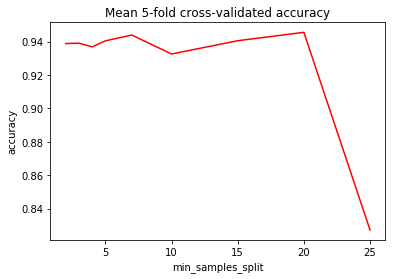

In [37]:
min_samples_splits = [2,3,4,5,7,10,15,20,25]
results = []
for min_samples_split in min_samples_splits:
    clf = DecisionTreeClassifier(min_samples_split=min_samples_split)
    scores = cross_validate(clf, df_vars, df_class, cv=5)
    results.append(scores['test_score'].mean())
    
plt.plot(min_samples_splits, results, "r", label="Test Accuracy")
plt.ylabel("accuracy")
plt.xlabel("min_samples_split")
plt.title("Mean 5-fold cross-validated accuracy")
plt.show()

### Model fitting and sample testing

In [49]:
model = clf.fit(X_train, y_train)
model.score(X_test, y_test)

0.925

### Final prediction

In [50]:
df_res = pd.DataFrame()
df_res['ID'] = df_test['ID']
df_res['class'] = pd.Series(model.predict(df_test))
df_res.head(10)

,ID,class
0,656,Harp
1,949,Mark
2,255,CFH
3,21,Agresti
4,1412,Vision
5,278,Chachra
6,81,Auken
7,1475,Wilson
8,955,Mark
9,1400,Vernon


### Export

In [51]:
export_file_name = result_folder + "svm_linear.csv"
df_res.to_csv(export_file_name, index=False)

### Easy comparison

In [22]:
import traceback
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

df_vars_all = df_train.loc[:, df_train.columns != 'Class']
df_vars_all = df_vars_all.drop('ID', axis=1)
df_class = df_train['Class']

#df_vars = KNN(k=3).fit_transform(df_vars)

names = ["Nearest Centroid", "Linear SVM",
         "Decision Tree", "Naive Bayes"]

classifiers = [
    NearestCentroid(),
    SVC(kernel="linear"),
    DecisionTreeClassifier(),
    GaussianNB()]

cl_scores = {}
for name in names:
    cl_scores[name] = []

for feature_count in [1,2,5,10,20,30,40,50,100,500,1000,10000, 0]:
    if feature_count != 0:
        df_vars = SelectKBest(chi2, k=20).fit_transform(df_vars_all, df_class)
    else:
        df_vars = df_vars_all
    print("-"*60)
    print("Feature count=", feature_count if feature_count > 0 else "ALL")
    for name, clf in zip(names, classifiers):
        try:
            np.random.seed(32143421)
            scores = cross_validate(clf, df_vars, df_class, cv=10, scoring='accuracy', return_train_score=True)
            cl_scores[name].append(scores)
            print(name,"-- Training Set --", "Mean", scores['train_score'].mean(), "-- Min", scores['train_score'].min(), "-- Max", scores['train_score'].max())
            print(name,"-- Test Set --", "Mean", scores['test_score'].mean(), "-- Min", scores['test_score'].min(), "-- Max", scores['test_score'].max())
        except:
            print("Classification failed for", name)
            traceback.print_exc()

------------------------------------------------------------
Feature count= 1
Nearest Centroid -- Training Set -- Mean 0.1364854545724934 -- Min 0.12465753424657534 -- Max 0.14611260053619302
Nearest Centroid -- Test Set -- Mean 0.09982102310931498 -- Min 0.047619047619047616 -- Max 0.15151515151515152
Linear SVM -- Training Set -- Mean 0.923873203197612 -- Min 0.9102209944751382 -- Max 0.9348441926345609
Linear SVM -- Test Set -- Mean 0.2593506119214463 -- Min 0.12962962962962962 -- Max 0.34285714285714286
Decision Tree -- Training Set -- Mean 1.0 -- Min 1.0 -- Max 1.0
Decision Tree -- Test Set -- Mean 0.21980551948933927 -- Min 0.1111111111111111 -- Max 0.3026315789473684
Naive Bayes -- Training Set -- Mean 0.32022794115725245 -- Min 0.30686406460296095 -- Max 0.32959326788218796
Naive Bayes -- Test Set -- Mean 0.2113958853230756 -- Min 0.15714285714285714 -- Max 0.30158730158730157
------------------------------------------------------------
Feature count= 2
Nearest Centroid -- Trai

### all features
Nearest Centroid -- Training Set -- Mean 0.7496791822186778 -- Min 0.7279005524861878 -- Max 0.7724039829302988
Nearest Centroid -- Test Set -- Mean 0.6628582456264915 -- Min 0.5873015873015873 -- Max 0.7543859649122807
Linear SVM -- Training Set -- Mean 1.0 -- Min 1.0 -- Max 1.0
Linear SVM -- Test Set -- Mean 0.9560670435070409 -- Min 0.9191919191919192 -- Max 1.0
Decision Tree -- Training Set -- Mean 1.0 -- Min 1.0 -- Max 1.0
Decision Tree -- Test Set -- Mean 0.9458952341983844 -- Min 0.9 -- Max 1.0
Naive Bayes -- Training Set -- Mean 1.0 -- Min 1.0 -- Max 1.0
Naive Bayes -- Test Set -- Mean 0.35593122949313594 -- Min 0.2727272727272727 -- Max 0.42857142857142855

In [19]:
traces = []
for clf_name in names:
    traces.append(go.Box(
        y=cl_scores[clf_name]['test_score'],
        boxpoints='all',
        name=clf_name
    ))
    
layout = go.Layout(title="Accuracy on Test Set (Amazon Commerce Reviews)")
    
py.iplot(go.Figure(data=traces, layout=layout))

TypeError: list indices must be integers or slices, not str

In [43]:
df_class.value_counts()

Blankenship    21
Sherwin        21
Vernon         21
Nigam          20
Taylor         19
Comdet         19
Mitchell       19
Chachra        18
Walters        18
Corn           18
Lovitt         18
Johnson        18
Koenig         18
Chandler       17
Hayes          17
Peterson       17
Janson         17
Morrison       17
Vision         17
Auken          17
McKee          16
Shea           16
Cutey          16
Kolln          16
Neal           16
Mahlers2nd     16
Wilson         15
Calvinnme      15
Harp           15
Dent           15
Lawyeraau      15
Chell          15
Engineer       15
Brown          15
Grove          15
Davisson       15
Power          15
Agresti        14
Bukowsky       14
Robert         14
Brody          14
CFH            14
Cholette       14
Messick        14
Merritt        13
Mark           13
Riley          13
Ashbacher      12
Lee            12
Goonan         11
Name: Class, dtype: int64

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
corr = df_vars.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [23]:
trace = []
names = ["Nearest Centroid", "Linear SVM",
         "Decision Tree", "Naive Bayes"]
feature_counts = [1,2,5,10,20,30,40,50,100,500,1000,10000, "All"]
for idx, feature_count in enumerate(feature_counts):
    for cl in names:
        for score in cl_scores[cl][idx]['test_score']:
            trace.append({'score': score, 'x':idx, 'name':feature_count, 'classifier':cl})
df_trace = pd.DataFrame.from_dict(trace)

E:\Python\Miniconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



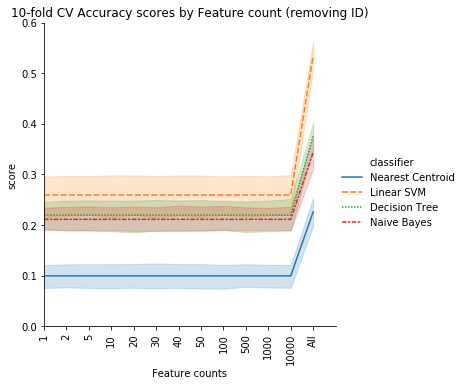

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
g = sns.relplot(x="x", y="score", kind="line", hue="classifier", style="classifier", data=df_trace)
plt.xticks(range(len(feature_counts)), feature_counts, rotation='vertical')
plt.xlabel("Feature counts")
plt.title("10-fold CV Accuracy scores by Feature count (removing ID)")
axes = plt.gca()
axes.set_ylim([0.0,0.6])
axes.set_xlim([0,len(feature_counts)])
plt.savefig('feature_cnt_eval_with_ID.pdf')
plt.show()

In [17]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

df_vars_all = df_train.loc[:, df_train.columns != 'Class']
#df_vars_all = df_vars_all.drop('ID', axis=1)
df_class = df_train['Class']
selector = SelectKBest(chi2, k=1)
selector.fit(df_vars_all, df_class)
cols = selector.get_support(indices=True)
best_features = df_vars_all.columns[cols]
#df_vars = SelectKBest(chi2, k=1).fit_transform(df_vars_all, df_class)
best_features

Index(['ID'], dtype='object')

In [41]:
sorted(df_train['Class'].unique())

['Agresti',
 'Ashbacher',
 'Auken',
 'Blankenship',
 'Brody',
 'Brown',
 'Bukowsky',
 'CFH',
 'Calvinnme',
 'Chachra',
 'Chandler',
 'Chell',
 'Cholette',
 'Comdet',
 'Corn',
 'Cutey',
 'Davisson',
 'Dent',
 'Engineer',
 'Goonan',
 'Grove',
 'Harp',
 'Hayes',
 'Janson',
 'Johnson',
 'Koenig',
 'Kolln',
 'Lawyeraau',
 'Lee',
 'Lovitt',
 'Mahlers2nd',
 'Mark',
 'McKee',
 'Merritt',
 'Messick',
 'Mitchell',
 'Morrison',
 'Neal',
 'Nigam',
 'Peterson',
 'Power',
 'Riley',
 'Robert',
 'Shea',
 'Sherwin',
 'Taylor',
 'Vernon',
 'Vision',
 'Walters',
 'Wilson']

In [33]:
df_test.sort_values(by='ID')

,ID,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V9991,V9992,V9993,V9994,V9995,V9996,V9997,V9998,V9999,V10000
669,1,5,3,4,4,1,5,1,3,2,...,1,0,0,0,1,0,1,0,0,0
655,3,3,2,2,4,4,2,2,2,3,...,2,0,0,6,0,0,0,0,1,0
618,4,18,4,6,5,4,2,1,0,4,...,0,0,0,0,0,0,0,0,0,0
403,5,13,4,7,5,4,5,0,1,0,...,0,0,0,1,0,0,1,1,0,0
300,9,21,2,6,6,5,5,1,2,1,...,0,0,0,0,0,0,0,1,1,0
313,11,20,3,8,5,7,10,0,1,0,...,1,1,0,0,0,0,0,0,0,0
309,12,8,3,3,1,3,1,1,0,2,...,0,0,0,0,1,0,0,0,0,0
215,13,10,6,5,3,2,3,3,1,0,...,2,0,1,0,0,0,0,0,0,0
193,16,15,5,0,2,5,2,1,1,0,...,0,0,2,0,0,0,0,1,1,0
491,17,7,2,6,1,6,9,1,2,3,...,0,0,0,0,1,0,0,0,1,0


In [46]:
class_labels = sorted(df_train['Class'].unique())
df_res = pd.DataFrame()
df_res['ID'] = df_test['ID']
df_res['class'] = df_test['ID'].apply(lambda x: class_labels[x//30])
df_res.head(10)

,ID,class
0,656,Harp
1,949,Mark
2,255,Calvinnme
3,21,Agresti
4,1412,Vision
5,278,Chachra
6,81,Auken
7,1475,Wilson
8,955,Mark
9,1400,Vernon


In [42]:
class_labels = sorted(df_train['Class'].unique())
df_res = pd.DataFrame()
df_res['ID'] = df_test['ID']
df_res['class'] = df_test['ID'].apply(lambda x: class_labels)
df_res.head(10)

In [44]:
class_labels[31//30]

'Ashbacher'

In [45]:
df_train['class_p'] = df_test['ID'].apply(lambda x: class_labels)

['Agresti',
 'Ashbacher',
 'Auken',
 'Blankenship',
 'Brody',
 'Brown',
 'Bukowsky',
 'CFH',
 'Calvinnme',
 'Chachra',
 'Chandler',
 'Chell',
 'Cholette',
 'Comdet',
 'Corn',
 'Cutey',
 'Davisson',
 'Dent',
 'Engineer',
 'Goonan',
 'Grove',
 'Harp',
 'Hayes',
 'Janson',
 'Johnson',
 'Koenig',
 'Kolln',
 'Lawyeraau',
 'Lee',
 'Lovitt',
 'Mahlers2nd',
 'Mark',
 'McKee',
 'Merritt',
 'Messick',
 'Mitchell',
 'Morrison',
 'Neal',
 'Nigam',
 'Peterson',
 'Power',
 'Riley',
 'Robert',
 'Shea',
 'Sherwin',
 'Taylor',
 'Vernon',
 'Vision',
 'Walters',
 'Wilson']

In [47]:
export_file_name = result_folder + "id_prediction.csv"
df_res.to_csv(export_file_name, index=False)

In [48]:
1400//30

46